<a href="https://colab.research.google.com/github/marcosw1998/Data-Science/blob/main-mwac/Project_ee2/predict_covid_spends_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise dos custos do governo de Pernambuco - BR em relação à Covid-19**
* Projeto corresponde a entrega parcial para avaliação na cadeira eletiva IF697 - Intro. a Ciência dos Dados
* Autores: Igor Silva e Marcos Cavalcanti
* Conjunto de dados públicos retirados das seguintes fontes:
  * [Portal da Transparência TCU](http://www.portaltransparencia.gov.br/coronavirus)
  * [Prefeitura do Recife](http://dados.recife.pe.gov.br/dataset?tags=sa%C3%BAde)
  * [Brasil.io](https://brasil.io/dataset/covid19/caso_full/)



## **Por quê o tema?**

* Interesse em entender e expor de forma clara os gastos públicos
* Analisar distribuição de gastos
* Covis-19 é um tema importante e merece muita atenção, pois tem feito muitas vítimas e mudado a forma como a sociedade pensa e se organiza
* Entender a distribuição de gastos é uma boa forma de tentar corrigir erros e minimizar danos futuros na economia e na sociedade

## **Carregando as bibliotecas**

  * Utilizaremos a biblioteca ***`Pandas`*** para trabalhar sobre os dados  e a biblioteca ***`Numpy`*** para operações sobre os datasets.
  



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

In [ ]:
pip install optuna

### Portal da transparência

* O portal da transparência permite que sejam baixados apenas 1000 registros por vez, portanto decidimos por baixar 2 datasets diferentes e depois fazermos a junção. Os dados são referentes a algumas cidades de Pernambuco 
(Recife, Jaboatão, Olinda, Paulista, Caruaru, Garanhuns, Petrolina, Arcoverde, Serra Talhada, Buíque)

In [2]:
invest_covidPe = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid-pe.csv",encoding = "utf-8")
invest_covidPe2 = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/transferencias_coronavirus.csv",encoding = "utf-8")

In [3]:
#Validando os dados do dataset invest_covidPe
print('Dataset 1',invest_covidPe.shape)
invest_covidPe.sort_values("Município").head()

Dataset 1 (561, 12)


,Mês/Ano,Tipo,Tipo de Favorecido,UF,Nome do Favorecido,CPF/CNPJ,Município,Função,Programa Orçamentário,Ação Orçamentária,Linguagem Cidadã,Valor Transferido
182,nov/20,Legais. Voluntárias e Específicas,Fundo Público,PE,FUNDO MUNICIPAL DE SAUDE,11.371.082/0001-05,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,Sem informação,486.515.00
178,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,ASSOCICAO DE PAIS E MESTRES,11.252.224/0001-07,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,7.897.02
179,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CONSELHO ESCOLAR MARIA DO SOCORRO DE FREITAS,02.021.769/0001-11,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,2.837.48
87,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CONSELHO ESCOLAR DOM BERNARDINO MARCHIO,34.179.420/0001-07,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,8.427.56
181,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,UNIDADE EXECUTORA MAJOR DR.SINVAL,11.441.171/0001-72,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,2.274.59


In [4]:
#Validando os dados do dataset invest_covidPe2
print('Dataset 2',invest_covidPe2.shape)
invest_covidPe2.sort_values("Município").head()

Dataset 2 (140, 10)


,Mês/Ano,Tipo,Ação Orçamentária,Programa Orçamentário,Função,Tipo de Favorecido,UF,Município,Valor Transferido,Unnamed: 9
98,12/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 134.639.00,NaN
41,05/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 470.809.62,NaN
42,11/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 355.594.00,NaN
32,04/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 761.895.71,NaN
56,08/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 218.971.54,NaN


*Podemos perceber que o Dataset **invest_covidPe** possui mais colunas que o Dataset **invest_covidPe2**.  Também notamos que o Dataset invest_covidPe2 possui uma coluna com dados Nan, vamos tratar disso no pré processamento antes de fazer a concatenação dos dois Datasets*

### Dados abertos - Prefeitura do Recife

In [5]:
import requests

dados_pref_rmr = requests.get("http://dados.recife.pe.gov.br/dataset/6c77a814-7161-4eb5-9662-234642dc8cc1/resource/63376b8c-0271-42eb-a88b-cc75c1c3f3fc/download/metadados-hospitais.json").json()

### Dados de casos de Covid-19 por todo o estado de Pernambuco. 
Os valores estão atualizados até o dia 17/03/2021 e foram buscados através do Brasil.io

In [6]:
covidPeCases = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid19-1703-casos.csv",encoding = "utf-8")
print(covidPeCases.shape)
covidPeCases.sort_values("city").head()

(187, 16)


,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population,is_last,is_repeated
1,202111,2021-03-15,341,PE,Abreu e Lima,2600054.0,city,1700,1694.13828,8,159,1,0.0935,100346.0,True,False
2,202111,2021-03-15,321,PE,Afogados da Ingazeira,2600104.0,city,2478,6624.95990,1,35,0,0.0141,37404.0,True,False
3,202111,2021-03-15,321,PE,Afrânio,2600203.0,city,578,2917.71832,0,9,0,0.0156,19810.0,True,False
4,202111,2021-03-15,326,PE,Agrestina,2600302.0,city,865,3451.02733,2,36,0,0.0416,25065.0,True,False
7,202111,2021-03-15,331,PE,Alagoinha,2600609.0,city,443,3009.91983,0,13,0,0.0293,14718.0,True,False


## **Pré Processamento**
  * Junção de datasets em Dataframe Pandas
  * Tratamento de dados ```NaN```/```null``` ou corrompidos
  * Conversão de tipos
  * Transformação e identificação de dados categóricos
  * Remoção de ***Outliers*** Multivariado

### **Tratamento dos dados de Gastos Públicos**

> Remoção colunas que não fazem parte do dataset invest_covidPe2 e que não influem sobre os nossos estudos (Nome do favorecido, CPF/CNPJ, Linguagem Cidadã)

>```invest_covidPe = invest_covidPe.dropna(axis=1, how='all')```

In [7]:
cols = [4,5,10]
invest_covidPe.drop(invest_covidPe.columns[cols],axis=1,inplace=True)
invest_covidPe.sort_values("Município").head()

,Mês/Ano,Tipo,Tipo de Favorecido,UF,Município,Função,Programa Orçamentário,Ação Orçamentária,Valor Transferido
182,nov/20,Legais. Voluntárias e Específicas,Fundo Público,PE,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,486.515.00
178,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,7.897.02
179,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.837.48
87,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,8.427.56
181,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.274.59


> Remoção coluna que tem todos os valores Nan

In [8]:
invest_covidPe2.dropna(axis=1, how='all',inplace=True)
invest_covidPe2.sort_values("Município").head()

,Mês/Ano,Tipo,Ação Orçamentária,Programa Orçamentário,Função,Tipo de Favorecido,UF,Município,Valor Transferido
98,12/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 134.639.00
41,05/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 470.809.62
42,11/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 355.594.00
32,04/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 761.895.71
56,08/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 218.971.54


> Retirando prefixo numérico e caracteres especiais dos valores da categoria 'Função'

In [9]:
invest_covidPe_funcao = invest_covidPe2['Função'].map(lambda words: str(words[5:]))
invest_covidPe2['Função'].update(invest_covidPe_funcao)
invest_covidPe2['Função'].unique()

array(['Educação', 'Saúde', 'Assistência social', 'Ciência e Tecnologia'],
      dtype=object)

> Confirmando que as colunas foram removidas e agora os 2 datasets possuem a mesma quantidade de colunas

In [10]:
print('Dataset 1',invest_covidPe.shape)
print('Dataset 2',invest_covidPe2.shape)

Dataset 1 (561, 9)
Dataset 2 (140, 9)


> Fazendo a concatenação dos Dataframes, o resultado final de linhas é igual ao somatório de linhas entre ambos os Datasets

In [11]:
invest_covidPe = invest_covidPe.append(invest_covidPe2, ignore_index=True)

> Filtragem de gastos com a saúde e retirada das colunas **Tipo**, **UF**, **Programa Orçamentário** e **Função** por não conterem dados variados.

In [12]:
len(invest_covidPe2['Tipo de Favorecido'].unique())

3

In [13]:
# Drop colunas com valores unitários

invest_covidPe.drop({'Tipo',\
                     'UF',\
                     'Ação Orçamentária'},\
                    axis=1,\
                    inplace=True \
                    )
invest_covidPe

,Mês/Ano,Tipo de Favorecido,Município,Função,Programa Orçamentário,Valor Transferido
0,mar/20,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,60.000.00
1,abr/20,Fundo Público,GARANHUNS,Saúde,ATENCAO ESPECIALIZADA A SAUDE,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,4.130.446.89
3,abr/20,Fundo Público,OLINDA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3.830.136.03
4,abr/20,Fundo Público,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3.662.675.00
...,...,...,...,...,...,...
696,04/2020,Fundo Público,JABOATÃO DOS GUARARAPES,Saúde,ATENCAO ESPECIALIZADA A SAUDE,R$ 7.327.021.87
697,10/2020,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,R$ 3.500.000.00
698,07/2020,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,R$ 8.676.053.00
699,07/2020,Fundo Público,BUÍQUE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,R$ 1.850.000.00


Renomeando colunas

In [14]:
invest_covidPe

,Mês/Ano,Tipo de Favorecido,Município,Função,Programa Orçamentário,Valor Transferido
0,mar/20,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,60.000.00
1,abr/20,Fundo Público,GARANHUNS,Saúde,ATENCAO ESPECIALIZADA A SAUDE,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,4.130.446.89
3,abr/20,Fundo Público,OLINDA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3.830.136.03
4,abr/20,Fundo Público,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3.662.675.00
...,...,...,...,...,...,...
696,04/2020,Fundo Público,JABOATÃO DOS GUARARAPES,Saúde,ATENCAO ESPECIALIZADA A SAUDE,R$ 7.327.021.87
697,10/2020,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,R$ 3.500.000.00
698,07/2020,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,R$ 8.676.053.00
699,07/2020,Fundo Público,BUÍQUE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,R$ 1.850.000.00


In [15]:
invest_covidPe = invest_covidPe.rename(columns={'Mês/Ano': 'month', \
                                                'Município': 'city', \
                                                'Tipo de Favorecido': 'tipo_favorecido', \
                                                'Programa Orçamentário': 'prog_orcamento', \
                                                'Valor Transferido': 'gastos' \
                                                })
invest_covidPe.head(3)

,month,tipo_favorecido,city,Função,prog_orcamento,gastos
0,mar/20,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,60.000.00
1,abr/20,Fundo Público,GARANHUNS,Saúde,ATENCAO ESPECIALIZADA A SAUDE,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,4.130.446.89


#### **Conversão de tipos das colunas**

  * Valor Transferido (rename -> gastos): ```string``` -> ```float```

  * Mês/Ano (rename -> data_hora): ```string``` -> ```pandas.Datetime```

  * Dados categóricos: ```object``` -> ```category```

In [16]:
invest_covidPe.dtypes

month              object
tipo_favorecido    object
city               object
Função             object
prog_orcamento     object
gastos             object
dtype: object

##### **Valor Transferido**
```object``` -> ```float64```

In [17]:
# Tratamento e conversão do CSV-String para float
invest_covidPe['valores_transferidos'] = invest_covidPe['gastos'].apply(lambda words: words.replace('R$ ', ''))
valores_transferidos = invest_covidPe['valores_transferidos'].map(lambda words: float(words[:-3].replace('.','') + words[-3:]))
valores_transferidos = valores_transferidos.astype('float64')
#valores_transferidos = valores_transferidos.astype(float)

In [18]:
invest_covidPe.head(3)

,month,tipo_favorecido,city,Função,prog_orcamento,gastos,valores_transferidos
0,mar/20,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,60.000.00,60.000.00
1,abr/20,Fundo Público,GARANHUNS,Saúde,ATENCAO ESPECIALIZADA A SAUDE,1.174.944.27,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,4.130.446.89,4.130.446.89


In [19]:
# Atualiza o dataset principal
invest_covidPe['gastos'].update(valores_transferidos)
invest_covidPe.drop('valores_transferidos',axis=1,inplace=True)
invest_covidPe = invest_covidPe.infer_objects()
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            701 non-null    object 
 1   tipo_favorecido  701 non-null    object 
 2   city             701 non-null    object 
 3   Função           701 non-null    object 
 4   prog_orcamento   701 non-null    object 
 5   gastos           701 non-null    float64
dtypes: float64(1), object(5)
memory usage: 33.0+ KB


##### **Data (timestamp)**
```object``` -> ```pandas.Datetime```

Obs.: Apenas necessário para o caso de análise de séries temporais.

In [20]:
#month = invest_covidPe['month'].map(lambda words: float(words.replace('jan/20','') + words[-3:]))
#invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('string')
#invest_covidPe.info(verbose=True)

In [21]:
#meses = {'mar/20' : '2020-03-10', \
    #     'abr/20' : '2020-04-10', \
     #    'mai/20' : '2020-05-10', \
    #     'jun/20' : '2020-06-10', \
     #    'jul/20' : '2020-07-10', \
     #    'ago/20' : '2020-08-10', \
   #      'set/20' : '2020-09-10', \
      #   'out/20' : '2020-10-10', \
      #   'nov/20' : '2020-11-10', \
      #   'dez/20' : '2020-12-10', \
      #   '03/2020' : '2020-03-10', \
        # '04/2020' : '2020-04-10', \
         #'05/2020' : '2020-05-10', \
        # '06/2020' : '2020-06-10', \
        # '07/2020' : '2020-07-10', \
       #  '08/2020' : '2020-08-10', \
      #   '09/2020' : '2020-09-10', \
      #   '10/2020' : '2020-10-10', \
     #    '11/2020' : '2020-11-10', \
      #   '12/2020' : '2020-12-10'
      #   }

#invest_covidPe['data_hora'] = invest_covidPe['data_hora'].apply(lambda dates: dates.replace(dates, meses[dates]))

#invest_covidPe['data_hora'].unique()

In [22]:
# convert the 'Date' column to datetime format
#invest_covidPe['data_hora'] = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
#invest_covidPe.info()

##### **Definindo dados categóricos**

Conversão de dados categóricos
> ```object``` -> ```category```

In [23]:
invest_covidPe

,month,tipo_favorecido,city,Função,prog_orcamento,gastos
0,mar/20,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,60000.00
1,abr/20,Fundo Público,GARANHUNS,Saúde,ATENCAO ESPECIALIZADA A SAUDE,1174944.27
2,abr/20,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,4130446.89
3,abr/20,Fundo Público,OLINDA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3830136.03
4,abr/20,Fundo Público,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3662675.00
...,...,...,...,...,...,...
696,04/2020,Fundo Público,JABOATÃO DOS GUARARAPES,Saúde,ATENCAO ESPECIALIZADA A SAUDE,7327021.87
697,10/2020,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3500000.00
698,07/2020,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,8676053.00
699,07/2020,Fundo Público,BUÍQUE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,1850000.00


In [24]:
invest_covidPe['month'] = invest_covidPe['month'].astype('category')
invest_covidPe['city'] = invest_covidPe['city'].astype('category')
invest_covidPe['Função'] = invest_covidPe['Função'].astype('category')
invest_covidPe['tipo_favorecido'] = invest_covidPe['tipo_favorecido'].astype('category')
invest_covidPe['prog_orcamento'] = invest_covidPe['prog_orcamento'].astype('category')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   month            701 non-null    category
 1   tipo_favorecido  701 non-null    category
 2   city             701 non-null    category
 3   Função           701 non-null    category
 4   prog_orcamento   701 non-null    category
 5   gastos           701 non-null    float64 
dtypes: category(5), float64(1)
memory usage: 10.7 KB


### **Tratamento dos dados de casos de covid-19 em PE**

Filtragem de categorias

In [25]:
covidPeCases = covidPeCases.filter(items=['city', \
                                         'last_available_confirmed', \
                                         'last_available_deaths', \
                                         'last_available_death_rate', \
                                         'estimated_population' \
                                         ])
covidPeCases

,city,last_available_confirmed,last_available_deaths,last_available_death_rate,estimated_population
0,NaN,323176,11510,0.0356,9616621.0
1,Abreu e Lima,1700,159,0.0935,100346.0
2,Afogados da Ingazeira,2478,35,0.0141,37404.0
3,Afrânio,578,9,0.0156,19810.0
4,Agrestina,865,36,0.0416,25065.0
...,...,...,...,...,...
182,Vertente do Lério,156,2,0.0128,7571.0
183,Vertentes,408,5,0.0123,20954.0
184,Vicência,431,16,0.0371,32772.0
185,Vitória de Santo Antão,3038,186,0.0612,139583.0


Renomeação de colunas

In [26]:
covidPeCases = covidPeCases.rename(columns={"city": "municipio", \
                                           "last_available_confirmed": "casos_confirmados", \
                                           "last_available_deaths": "mortes_confirmadas", \
                                           "last_available_death_rate": "taxa_mortalidade", \
                                           "estimated_population": "pop_estimada" \
                                           })
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada
0,NaN,323176,11510,0.0356,9616621.0
1,Abreu e Lima,1700,159,0.0935,100346.0
2,Afogados da Ingazeira,2478,35,0.0141,37404.0
3,Afrânio,578,9,0.0156,19810.0
4,Agrestina,865,36,0.0416,25065.0
...,...,...,...,...,...
182,Vertente do Lério,156,2,0.0128,7571.0
183,Vertentes,408,5,0.0123,20954.0
184,Vicência,431,16,0.0371,32772.0
185,Vitória de Santo Antão,3038,186,0.0612,139583.0


Filtrar cidades do dataset de Gastos públicos

In [27]:
#Guardando uma cópia dos dados de todas as cidades
oldCovidPeCases = covidPeCases

#Filtrando as cidades que selecionamos os gastos no portal da transparência
cities = ['Arcoverde', \
          'Buíque', \
          'Caruaru', \
          'Garanhuns', \
          'Jaboatão dos Guararapes', \
          'Olinda', \
          'Paulista', \
          'Petrolina', \
          'Recife', \
          'Serra Talhada']

covidPeCases = covidPeCases[covidPeCases.municipio.isin(cities)]
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada
14,Arcoverde,4281,87,0.0203,74822.0
30,Buíque,1436,23,0.0160,58919.0
45,Caruaru,17187,454,0.0264,365278.0
67,Garanhuns,7250,134,0.0185,140577.0
89,Jaboatão dos Guararapes,19966,1095,0.0548,706867.0
113,Olinda,14581,635,0.0435,393115.0
124,Paulista,7154,528,0.0738,334376.0
128,Petrolina,18239,209,0.0115,354317.0
134,Recife,78117,3168,0.0406,1653461.0
160,Serra Talhada,7341,105,0.0143,86915.0


In [28]:
covidPeCases.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 14 to 160
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   municipio           10 non-null     object 
 1   casos_confirmados   10 non-null     int64  
 2   mortes_confirmadas  10 non-null     int64  
 3   taxa_mortalidade    10 non-null     float64
 4   pop_estimada        10 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 480.0+ bytes


In [29]:
covidPeCases['municipio'] = covidPeCases['municipio'].apply(lambda city: city.upper())
covidPeCases['municipio'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array(['ARCOVERDE', 'BUÍQUE', 'CARUARU', 'GARANHUNS',
       'JABOATÃO DOS GUARARAPES', 'OLINDA', 'PAULISTA', 'PETROLINA',
       'RECIFE', 'SERRA TALHADA'], dtype=object)

In [30]:
covidPeCases['municipio'] = covidPeCases['municipio'].astype('category')
covidPeCases['id'] = covidPeCases['municipio'].cat.codes
covidPeCases.index = covidPeCases['id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,id
id,,,,,,
0,ARCOVERDE,4281,87,0.0203,74822.0,0
1,BUÍQUE,1436,23,0.0160,58919.0,1
2,CARUARU,17187,454,0.0264,365278.0,2
3,GARANHUNS,7250,134,0.0185,140577.0,3
4,JABOATÃO DOS GUARARAPES,19966,1095,0.0548,706867.0,4
5,OLINDA,14581,635,0.0435,393115.0,5
6,PAULISTA,7154,528,0.0738,334376.0,6
7,PETROLINA,18239,209,0.0115,354317.0,7
8,RECIFE,78117,3168,0.0406,1653461.0,8


### **Remoção de outliers multivariado**
> Método utilizado:
  * Local Outlier Factor

> Conjunto:
  * ```investCovidPE```

Categorizando Gastos públicos

Método para vincular os dados de municípios entre os dois Conjuntos de Dados

In [32]:
def categorizar_municipio(city):
  return covidPeCases[covidPeCases['municipio'] == str(city)].index.values.astype(int)[0]

In [33]:
invest_covidPe

,month,tipo_favorecido,city,Função,prog_orcamento,gastos
0,mar/20,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,60000.00
1,abr/20,Fundo Público,GARANHUNS,Saúde,ATENCAO ESPECIALIZADA A SAUDE,1174944.27
2,abr/20,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,4130446.89
3,abr/20,Fundo Público,OLINDA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3830136.03
4,abr/20,Fundo Público,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3662675.00
...,...,...,...,...,...,...
696,04/2020,Fundo Público,JABOATÃO DOS GUARARAPES,Saúde,ATENCAO ESPECIALIZADA A SAUDE,7327021.87
697,10/2020,Fundo Público,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,3500000.00
698,07/2020,Fundo Público,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,8676053.00
699,07/2020,Fundo Público,BUÍQUE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,1850000.00


In [34]:
invest_covidPe['city'] = invest_covidPe['city'].map(lambda city: city.replace(city, str(categorizar_municipio(city))))
invest_covidPe['month'] = invest_covidPe['month'].cat.codes
invest_covidPe['tipo_favorecido'] = invest_covidPe['tipo_favorecido'].cat.codes
invest_covidPe['Função'] = invest_covidPe['Função'].cat.codes
invest_covidPe['prog_orcamento'] = invest_covidPe['prog_orcamento'].cat.codes

In [35]:
invest_covidPe

,month,tipo_favorecido,city,Função,prog_orcamento,gastos
0,16,2,8,3,0,60000.00
1,10,2,3,3,0,1174944.27
2,10,2,7,3,0,4130446.89
3,10,2,5,3,0,3830136.03
4,10,2,2,3,0,3662675.00
...,...,...,...,...,...,...
696,1,2,4,3,0,7327021.87
697,7,2,8,3,0,3500000.00
698,4,2,7,3,0,8676053.00
699,4,2,1,3,0,1850000.00


#### **Local Outlier Factor**

In [36]:
invest_covidPe_lof = invest_covidPe
print("Quantidade de linhas: " + str(len(invest_covidPe)))

Quantidade de linhas: 701


In [37]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)

In [38]:
scores = clf.fit_predict(invest_covidPe_lof)

In [39]:
# Valor de LOF
-1*clf.negative_outlier_factor_

array([ 5.06971635,  1.15786907,  1.01278478,  1.00743069,  0.97511367,
        1.38735342,  1.14246381,  0.98157289,  0.9388996 ,  1.06181494,
        1.03345647,  1.00099309,  1.46929685,  0.96742528,  1.19792081,
        1.05815846,  1.32094043,  1.11359083,  0.88391166,  1.28701849,
        1.0212535 ,  1.05815846,  1.0811027 ,  1.03028305,  0.96950344,
        1.09989847,  1.71633666,  1.09000524,  1.17392687,  1.32513031,
        1.24460724,  1.24460724,  0.98706486,  0.95898566,  0.9073941 ,
        1.17776213,  1.30074647,  0.94080509,  1.1715444 ,  1.04785782,
        0.98969908,  1.22973992,  0.93931047,  1.10569106,  1.11086791,
        1.01557319,  0.95207123,  1.0404531 ,  1.40262619,  1.03760092,
        0.98506443,  1.31220318,  0.94483734,  1.00836771,  1.03237359,
        1.37091875,  1.17742638,  0.99612669,  1.02220098,  0.93716132,
        0.99639615,  1.03665054,  1.04930928,  1.3951037 ,  1.09881899,
        1.15364448,  1.13640352,  1.02526121,  1.08286789,  0.97

In [40]:
scores

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [41]:
invest_covidPe_lof['outlier'] = scores
print(invest_covidPe_lof.head())

   month  tipo_favorecido city  Função  prog_orcamento      gastos  outlier
0     16                2    8       3               0    60000.00       -1
1     10                2    3       3               0  1174944.27        1
2     10                2    7       3               0  4130446.89        1
3     10                2    5       3               0  3830136.03        1
4     10                2    2       3               0  3662675.00        1


In [42]:
invest_covidPe_lof[invest_covidPe_lof['outlier'] == -1]

,month,tipo_favorecido,city,Função,prog_orcamento,gastos,outlier
0,16,2,8,3,0,60000.00,-1
26,14,2,8,0,2,2264395.80,-1
96,17,1,8,2,1,-534.86,-1
149,17,1,8,2,1,-1084.16,-1
212,17,1,7,2,1,12037.82,-1
241,17,1,8,2,1,-1248.01,-1
243,17,1,8,2,1,-2529.72,-1
259,17,1,2,2,1,1342.91,-1
562,8,1,8,2,1,-1619.02,-1
589,8,1,8,2,1,-3777.73,-1


In [43]:
invest_covidPe_lof = invest_covidPe_lof[invest_covidPe_lof['outlier'] != -1]
len(invest_covidPe_lof)

688

In [44]:
invest_covidPe_lof = invest_covidPe_lof[invest_covidPe_lof['outlier'] != -1]
invest_covidPe_lof = invest_covidPe_lof.drop(columns=['outlier'])

invest_covidPe_lof.head(5)

,month,tipo_favorecido,city,Função,prog_orcamento,gastos
1,10,2,3,3,0,1174944.27
2,10,2,7,3,0,4130446.89
3,10,2,5,3,0,3830136.03
4,10,2,2,3,0,3662675.00
5,10,2,4,3,0,7327021.87


In [45]:
covidPeCases['pop_estimada'] = covidPeCases['pop_estimada'].astype('int64')
covidPeCases['taxa_mortalidade'] = covidPeCases['taxa_mortalidade'] * 100
#covidPeCases['confirmados_por_populacao'] = (covidPeCases['confirmados_por_populacao'] * 100).round(2)
#covidPeCases['gastos_por_habitante'] = (covidPeCases['gastos'] / covidPeCases['pop_estimada']).round(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
invest_covidPe_lof

,month,tipo_favorecido,city,Função,prog_orcamento,gastos
1,10,2,3,3,0,1174944.27
2,10,2,7,3,0,4130446.89
3,10,2,5,3,0,3830136.03
4,10,2,2,3,0,3662675.00
5,10,2,4,3,0,7327021.87
...,...,...,...,...,...,...
696,1,2,4,3,0,7327021.87
697,7,2,8,3,0,3500000.00
698,4,2,7,3,0,8676053.00
699,4,2,1,3,0,1850000.00


# Projeto 2



1. Escolher uma	das	colunas	dos	dados	utilizados	no	projeto 1	para predição	(classificação ou regressão)	
  * Classificação : Rótulos são categorias discretas
  * Regressão: rótulos são valores contínuos
2. Separar os	dados	em treinamento,	validação	e	teste
3. Selecionar	4	algoritmos	de	acordo	com	a	tarefa escolhida
no	passo	1	

 **Algoritmos de classificação:**

* Scikit-Learn's Estimator API
  - Vários algoritmos implementados
  - Uniformidade
  - Modelos para algoritmo Supervisionado: função predict e Não-supervisionado: função transform ou predict
* Random Forest 
  - Vários estimadores combinados para evitar overfitting
  - Não assume distribuição gaussiana, obtém ótimos resultados

* Algoritmo de construção  
  - Execução rápida, lida bem com dados ausentes
  - Mostra a importância das features na classificação
  

**Medidas para avaliação da qualidade do modelo:**
Os valores de erro são dados em '%'

* Viés = Erro no treinamento - Erro Alvo (Desempenho no conjunto de treinamento)
* Variância = Erro no teste - Erro no treinamento


Possíveis cenários de viés e Variância

Overfitting:
  - Bom desempenho somente no conjunto de treinamento.
  - Apresenta problemas para generalizar
  - Ex : Erro no treinamento: 1%, Erro no teste: 11% (Baixo viés, Alta variância)
  - Para melhorar o desempenho : Adicionar mais dados ao conjunto de treinamento, diminuir a complexidade do modelo, selecionar melhor as features.

Underfitting:
  - Não modela bem o conjunto de treinamento, problemas em generalizar
  - Ex: Erro no treinamento 15%, Erro no teste: 16% (ALto viés, Baixa variância)
 - Para melhorar o desempenho : Aumentar a complexidade, adicionar mais features.

Caso ideal:
  - Erro no treinamento: 0.5%, Erro no teste: 1%


## Classificação 1

> Classificadores com baixa complexidade (Supervisionado)
  * NaiveBayes
  * Decision Tree

Preparando os dados

In [232]:
from sklearn.model_selection import train_test_split
#Dividindo o dataframe em 60% para treinamento, 20% para validação e  20% para testes
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

ClassTest = invest_covidPe_lof
X_ClassTest = ClassTest.drop('prog_orcamento', axis=1)
Y_ClassTest = ClassTest['prog_orcamento']

# train is now 60% of the entire data set
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_ClassTest, Y_ClassTest, random_state=3, test_size= 1 - train_ratio)

# test is now 20% of the initial data set
# validation is now 20% of the initial data set
Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, random_state=3, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(Xtrain['city'].count(), Xval['city'].count(), Xtest['city'].count())

412 138 138
688


### Naive Bayes

In [233]:
from sklearn.naive_bayes import GaussianNB   # 1. escolha da técnica
NBmodel = GaussianNB()                       # 2. instanciação do modelo
NBmodel.fit(Xtrain, Ytrain)                  # 3. criação do modelo
Y_NBModel_test =  NBmodel.predict(Xtest)     # 4. predição com dados de teste
Y_NBModel_train = NBmodel.predict(Xtrain)    # 5. predição com dados de treino 

In [234]:
from sklearn.metrics import accuracy_score
print("ACC TRAINING:" + str(accuracy_score(Ytrain, Y_NBModel_train)))
print("ACC TEST:" + str(accuracy_score(Ytest, Y_NBModel_test)))

ACC TRAINING:0.8349514563106796
ACC TEST:0.8695652173913043


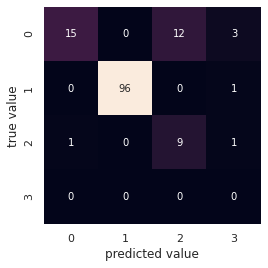

In [235]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(Ytest, Y_NBModel_test)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

### Decision Tree

In [236]:
from sklearn import tree                     # 1. escolha da técnica
treeModel = tree.DecisionTreeClassifier()    # 2. instanciação do modelo
treeModel.fit(Xtrain, Ytrain)                # 3. criação do modelo
YTreeModel_test = treeModel.predict(Xtest)   # 4. predição com dados de teste
YTreeModel_train = treeModel.predict(Xtrain) # 5. predição com dados de treino

In [237]:
print("ACC TRAINING:" + str(accuracy_score(Ytrain, YTreeModel_train)))
print("ACC TEST:" + str(accuracy_score(Ytest, YTreeModel_test)))

ACC TRAINING:1.0
ACC TEST:0.9782608695652174


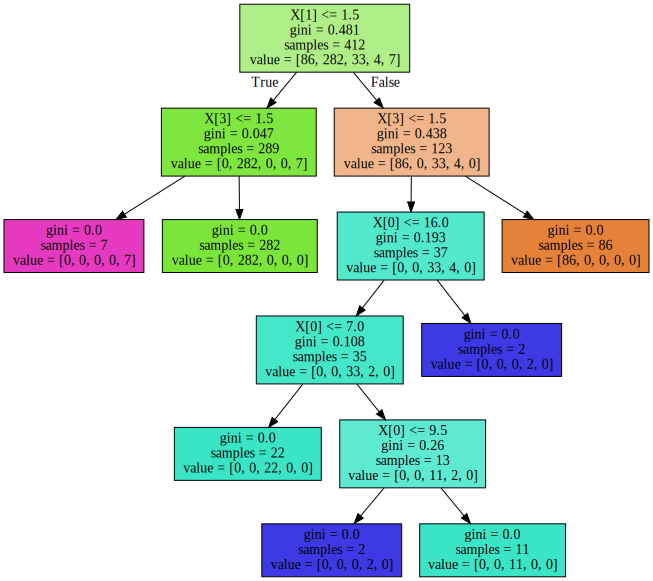

In [238]:
import graphviz 
dot_data = tree.export_graphviz(treeModel, out_file=None,filled=True) 
graph = graphviz.Source(dot_data, format="png") 
graph

### **F1Score**

'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall

https://scikit-learn.org/stable/modules/model_evaluation.html

Naive Bayes

In [239]:
from sklearn.metrics import f1_score
print('Teste, Treino')
print('Macro',f1_score(Y_NBModel_test, Ytest, average='macro'),f1_score(Y_NBModel_train, Ytrain, average='macro'))
print('Micro',f1_score(Y_NBModel_test, Ytest, average='micro'),f1_score(Y_NBModel_train, Ytrain, average='micro'))
print('Weighted',f1_score(Y_NBModel_test, Ytest, average='weighted'),f1_score(Y_NBModel_train, Ytrain, average='weighted'))
print('None',f1_score(Y_NBModel_test, Ytest, average=None).max(),f1_score(Y_NBModel_train, Ytrain, average=None).max())

Teste, Treino
Macro 0.5523731414733049 0.47825792632408515
Micro 0.8695652173913043 0.8349514563106796
Weighted 0.8532599513208028 0.8327998092140572
None 0.9948186528497409 0.9823943661971831


Decision Tree

In [240]:
print('Teste, Treino')
print('Macro',f1_score(YTreeModel_test, Ytest, average='macro'),f1_score(YTreeModel_train, Ytrain, average='macro'))
print('Micro',f1_score(YTreeModel_test, Ytest, average='micro'),f1_score(YTreeModel_train, Ytrain, average='micro'))
print('Weighted',f1_score(YTreeModel_test, Ytest, average='weighted'),f1_score(YTreeModel_train, Ytrain, average='weighted'))
print('None',f1_score(YTreeModel_test, Ytest, average=None).max(),f1_score(YTreeModel_train, Ytrain, average=None).max())

Teste, Treino
Macro 0.7269235280319024 1.0
Micro 0.9782608695652174 1.0
Weighted 0.9749861463825911 1.0
None 0.989795918367347 1.0


## Classificação 2
> Classificadores com maior complexidade (Supervisionado)
  * KNN
  * Random Forest

### KNN

In [241]:
from sklearn.neighbors  import KNeighborsClassifier  # 1. escolha da técnica
KNNmodel = KNeighborsClassifier(n_neighbors=1)        # 2. instanciação do modelo
KNNmodel.fit(Xtrain, Ytrain)                          # 3. criação do modelo
Y_KNNmodel_test =  KNNmodel.predict(Xtest)            # 4. predição com dados de teste
Y_KNNmodel_train = KNNmodel.predict(Xtrain)           # 5. predição com dados de treino 

In [242]:
print("ACC TRAINING:" + str(accuracy_score(Ytrain, Y_KNNmodel_train)))
print("ACC TEST:" + str(accuracy_score(Ytest, Y_KNNmodel_test)))

ACC TRAINING:1.0
ACC TEST:0.927536231884058


*Buscando os valor de K que deixa o modelo com acurácia maior. Variando de 1 à 31.* 

In [243]:
# varia o k de 1 a 30
k_range = range(1, 31)

k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtrain, Ytrain, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y ha

[0.9150455480458419, 0.8736996767558036, 0.8785777255362914, 0.8761387011460476, 0.8713194240376139, 0.8640905083749633, 0.8786658830443725, 0.8834557743167792, 0.8907140758154568, 0.8858947987070233, 0.888333823097267, 0.8810461357625625, 0.8858947987070233, 0.8810755215985895, 0.8810755215985895, 0.8737584484278578, 0.8713194240376139, 0.8712900382015867, 0.8712900382015867, 0.8664707610931531, 0.86650014692918, 0.8616514839847194, 0.868939171319424, 0.8689097854833969, 0.8615927123126653, 0.8591536879224213, 0.8567146635321775, 0.8664413752571261, 0.8591536879224213, 0.8567440493682046]


Text(0, 0.5, 'Cross-Validated Accuracy')

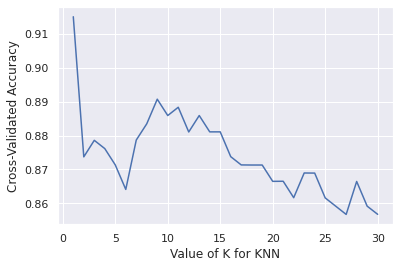

In [244]:
# plotando o valor de K versus a acurácia no cross-validation
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

### **Otimizando os parâmetros**
Escolhemos os seguintes parâmetros para serem otimizados:

*   n_neighbors
*   weights
*   leaf_size




In [265]:
  def eval_classifier_metrics(real_values, predict, train=True):
    accuracy = accuracy_score(real_values, predict)
    
    if(train):
        classifier_metrics = {'train_accuracy': accuracy}
    else:
        classifier_metrics = {'test_accuracy': accuracy}
    
    return classifier_metrics
  
  def objective(trial):
    x_df = Xval
    target = Yval
    
    classifier_name = trial.suggest_categorical('classifier', ['KNeighborsClassifier'])
    n_neighbors  = trial.suggest_int('n_neighbors', 1, 20, step=1)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    leaf_size = trial.suggest_int('leaf_size', 10, 60)
    
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size)
    classifier_obj.fit(x_df, target)
    predict = classifier_obj.predict(x_df)

    metrics = eval_classifier_metrics(target, predict, False)
    accuracy = metrics['test_accuracy']
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)

[I 2021-04-20 17:14:51,651] A new study created in memory with name: no-name-b7bbb10e-5069-49eb-bb8c-11634a22ba65
[I 2021-04-20 17:14:51,661] Trial 0 finished with value: 1.0 and parameters: {'classifier': 'KNeighborsClassifier', 'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 11}. Best is trial 0 with value: 1.0.
[I 2021-04-20 17:14:51,671] Trial 1 finished with value: 1.0 and parameters: {'classifier': 'KNeighborsClassifier', 'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 19}. Best is trial 0 with value: 1.0.
[I 2021-04-20 17:14:51,686] Trial 2 finished with value: 0.9202898550724637 and parameters: {'classifier': 'KNeighborsClassifier', 'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 10}. Best is trial 0 with value: 1.0.
[I 2021-04-20 17:14:51,695] Trial 3 finished with value: 1.0 and parameters: {'classifier': 'KNeighborsClassifier', 'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 41}. Best is trial 0 with value: 1.0.
[I 2021-04-20 17:14:51,710] Trial 4 fi

FrozenTrial(number=0, values=[1.0], datetime_start=datetime.datetime(2021, 4, 20, 17, 14, 51, 654781), datetime_complete=datetime.datetime(2021, 4, 20, 17, 14, 51, 661581), params={'classifier': 'KNeighborsClassifier', 'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 11}, distributions={'classifier': CategoricalDistribution(choices=('KNeighborsClassifier',)), 'n_neighbors': IntUniformDistribution(high=20, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'leaf_size': IntUniformDistribution(high=60, low=10, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


Melhores valores estimados

*   n_neighbors: 14
*   weights: 'distance'
*   leaf_size : 11

In [270]:
from sklearn.neighbors  import KNeighborsClassifier  # 1. escolha da técnica
Tunned_KNNmodel = KNeighborsClassifier(n_neighbors=13, weights='distance',leaf_size=11)        # 2. instanciação do modelo
Tunned_KNNmodel.fit(Xtrain, Ytrain)                          # 3. criação do modelo
TunnedY_KNNmodel_test =  Tunned_KNNmodel.predict(Xtest)            # 4. predição com dados de teste
TunnedY_KNNmodel_train = Tunned_KNNmodel.predict(Xtrain)           # 5. predição com dados de treino 

In [269]:
print("ACC TRAINING:" + str(accuracy_score(Ytrain, TunnedY_KNNmodel_train)))
print("ACC TEST:" + str(accuracy_score(Ytest, TunnedY_KNNmodel_test)))

ACC TRAINING:1.0
ACC TEST:0.9420289855072463


O modelo mostrou uma melhora de ~1,4% no teste após a otimização, passando de uma acurácia de 92,8% para 94,2%

A acurácia de treinamento se manteve fixa em 100%

### Random Forest

In [259]:
from sklearn.ensemble  import RandomForestClassifier  # 1. escolha da técnica
RFmodel = RandomForestClassifier(n_estimators=20)     # 2. instanciação do modelo
RFmodel.fit(Xtrain, Ytrain)                           # 3. criação do modelo
Y_RFmodel_test =  RFmodel.predict(Xtest)              # 4. predição com dados de teste
Y_RFmodel_train = RFmodel.predict(Xtrain)             # 5. predição com dados de treino

In [272]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('Training')
print(classification_report(Ytrain,Y_RFmodel_train))

print('Test')
print(classification_report(Ytest,Y_RFmodel_test))

Training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00       282
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         7

    accuracy                           1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412

Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        97
           2       1.00      0.91      0.95        11
           3       0.00      0.00      0.00         0

    accuracy                           0.99       138
   macro avg       0.75      0.73      0.74       138
weighted avg       1.00      0.99      1.00       138

ACC TRAINING:1.0
ACC TEST:0.9927536231884058


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



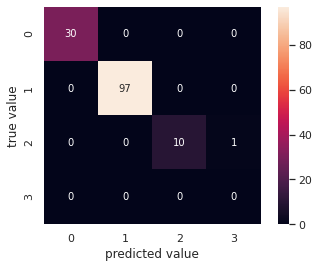

In [261]:
cm = confusion_matrix(Ytest,Y_RFmodel_test)

sns.heatmap(cm, square=True, annot=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

### **Otimizando os parâmetros**
Escolhemos os seguintes parâmetros para serem otimizados:

*   n_estimators
*   max_depth
*   max_features




In [248]:
import optuna
import sklearn.model_selection

In [250]:
  def eval_classifier_metrics(real_values, predict, train=True):
    accuracy = accuracy_score(real_values, predict)
    
    if(train):
        classifier_metrics = {'train_accuracy': accuracy}
    else:
        classifier_metrics = {'test_accuracy': accuracy}
    
    return classifier_metrics
  
  def objective(trial):
    x_df = Xval
    target = Yval
    
    classifier_name = trial.suggest_categorical('classifier', ['RandomForestClassifier'])
    n_estimators = trial.suggest_int('n_estimators', 10, 1000, step=10)
    max_depth = trial.suggest_int('max_depth', 10, 110, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    
    classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    classifier_obj.fit(x_df, target)
    predict = classifier_obj.predict(x_df)

    metrics = eval_classifier_metrics(target, predict, False)
    accuracy = metrics['test_accuracy']
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-04-20 16:50:40,934] A new study created in memory with name: no-name-daef2236-321e-4b8d-bb75-b1cb9db267a2
[I 2021-04-20 16:50:41,675] Trial 0 finished with value: 1.0 and parameters: {'classifier': 'RandomForestClassifier', 'n_estimators': 520, 'max_depth': 43, 'max_features': 'auto'}. Best is trial 0 with value: 1.0.
[I 2021-04-20 16:50:42,795] Trial 1 finished with value: 1.0 and parameters: {'classifier': 'RandomForestClassifier', 'n_estimators': 820, 'max_depth': 106, 'max_features': 'auto'}. Best is trial 0 with value: 1.0.
[I 2021-04-20 16:50:43,316] Trial 2 finished with value: 1.0 and parameters: {'classifier': 'RandomForestClassifier', 'n_estimators': 380, 'max_depth': 56, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.0.
[I 2021-04-20 16:50:43,838] Trial 3 finished with value: 1.0 and parameters: {'classifier': 'RandomForestClassifier', 'n_estimators': 370, 'max_depth': 17, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.0.
[I 2021-04-20 16:50:45,054] T

FrozenTrial(number=0, values=[1.0], datetime_start=datetime.datetime(2021, 4, 20, 16, 50, 40, 938066), datetime_complete=datetime.datetime(2021, 4, 20, 16, 50, 41, 675321), params={'classifier': 'RandomForestClassifier', 'n_estimators': 520, 'max_depth': 43, 'max_features': 'auto'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForestClassifier',)), 'n_estimators': IntUniformDistribution(high=1000, low=10, step=10), 'max_depth': IntUniformDistribution(high=110, low=10, step=1), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


Melhores valores estimados

*   n_estimators: 520
*   max_depth: 43
*   max_features : 'auto'

In [262]:
from sklearn.ensemble  import RandomForestClassifier  # 1. escolha da técnica
Tunned_RFmodel = RandomForestClassifier(n_estimators=520, max_depth= 43, max_features='auto')     # 2. instanciação do modelo
Tunned_RFmodel.fit(Xtrain, Ytrain)                           # 3. criação do modelo
TunnedY_RFmodel_test =  Tunned_RFmodel.predict(Xtest)              # 4. predição com dados de teste
TunnedY_RFmodel_train = Tunned_RFmodel.predict(Xtrain)             # 5. predição com dados de treino 

In [263]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('Training')
print(classification_report(Ytrain,TunnedY_RFmodel_train))

print('Test')
print(classification_report(Ytest,TunnedY_RFmodel_test))

Training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00       282
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         7

    accuracy                           1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412

Test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        97
           2       1.00      1.00      1.00        11

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



In [273]:
print("Antes do tunning")
print("ACC TRAINING:" + str(accuracy_score(Ytrain, Y_RFmodel_train)))
print("ACC TEST:" + str(accuracy_score(Ytest, Y_RFmodel_test)))

print("Depois do tunning")
print("ACC TRAINING:" + str(accuracy_score(Ytrain, TunnedY_RFmodel_train)))
print("ACC TEST:" + str(accuracy_score(Ytest, TunnedY_RFmodel_test)))


Antes do tunning
ACC TRAINING:1.0
ACC TEST:0.9927536231884058
Depois do tunning
ACC TRAINING:1.0
ACC TEST:1.0


O modelo mostrou uma melhora de ~0,7% no teste após a otimização, passando de uma acurácia de 99,3% para 100%

A acurácia de treinamento se manteve fixa em 100%

## Regressão

In [ ]:
RecifeInvest = invest_covidPe[(invest_covidPe['municipio']=='8')]

In [ ]:
RegressionTest = RecifeInvest[['data_hora','gastos']]

In [ ]:
RegressionTest.shape

(24, 2)

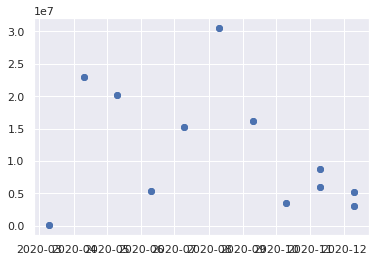

In [ ]:
plt.scatter(RegressionTest['data_hora'], RegressionTest['gastos'])

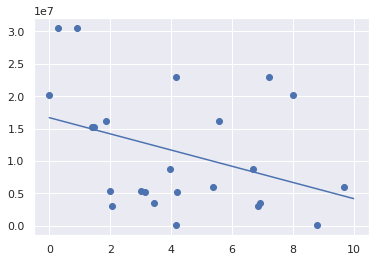

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

rng = np.random.RandomState(1)
x = 10 * rng.rand(24)

#x = RegressionTest['gastos']
y = RegressionTest['gastos']

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [ ]:
print("Model inclinação:      {:.3f}".format(model.coef_[0]))
print("Model intercepto:     {:.3f}".format(model.intercept_))

Model inclinação:      -1249695.775
Model intercepto:     16697329.756


In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

X = sm.add_constant(x)
models = sm.OLS(y, X)
results = models.fit()

In [ ]:
print("Model slope:      {:.3f}".format(results.params[1]))
print("Model intercept: {:.3f}".format(results.params[0]))

Model slope:      -1249695.775
Model intercept: 16697329.756


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns; sns.set()
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 4)
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'
rcParams['lines.linewidth'] = 2.0

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#Data from http://transparencia.recife.pe.gov.br/codigos/web/covid19vacinados/vacinados.php

RecifeVaccines = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/vacinados_2021-04-04-11-04.csv",encoding = "utf-8")

In [ ]:
RecifeVaccines

,Grupo,Dose,Data Vacina
0,IDOSOS,2,04/04/2021
1,IDOSOS,2,04/04/2021
2,IDOSOS,2,04/04/2021
3,IDOSOS,2,04/04/2021
4,TRABALHADORES DA SAÃšDE,1,04/04/2021
...,...,...,...
59447,TRABALHADORES DA SAÃšDE,2,11/04/2021
59448,IDOSOS,2,11/04/2021
59449,IDOSOS,2,11/04/2021
59450,IDOSOS,1,11/04/2021


In [ ]:
#x = ['04/04/2021','05/04/2021','06/04/2021','07/04/2021','08/04/2021','09/04/2021','10/04/2021','11/04/2021']

 #RecifeVaccines.groupby(level="Data Vacina").sum()
#x = RecifeVaccines["Data Vacina"].unique()

#x = pd.DataFrame({"Date": RecifeVaccines['Data Vacina'].unique()})

#x["Date"] = pd.to_datetime(x["Date"]).dt.strftime("%m")
#print( x )

['04/04/2021' '05/04/2021' '06/04/2021' '07/04/2021' '08/04/2021'
 '09/04/2021' '10/04/2021' '11/04/2021']


In [ ]:
x = np.array([4,5,6,7,8,9,10,11])
x = x.reshape(1, -1)
x

array([[ 4,  5,  6,  7,  8,  9, 10, 11]])

In [ ]:
 #RecifeVaccines.groupby(level="Data Vacina").sum()
y = RecifeVaccines.groupby(by="Data Vacina").sum()['Dose'].values

In [ ]:
Dose1 = RecifeVaccines[(RecifeVaccines['Dose']== 1)]
Dose1

,Grupo,Dose,Data Vacina
4,TRABALHADORES DA SAÃšDE,1,04/04/2021
7,IDOSOS,1,04/04/2021
15,IDOSOS,1,04/04/2021
19,IDOSOS,1,04/04/2021
21,IDOSOS,1,04/04/2021
...,...,...,...
59441,TRABALHADORES DA SAÃšDE,1,11/04/2021
59442,IDOSOS,1,11/04/2021
59446,IDOSOS,1,11/04/2021
59450,IDOSOS,1,11/04/2021


In [ ]:
Dose2 = RecifeVaccines[(RecifeVaccines['Dose']== 2)]
Dose2

,Grupo,Dose,Data Vacina
0,IDOSOS,2,04/04/2021
1,IDOSOS,2,04/04/2021
2,IDOSOS,2,04/04/2021
3,IDOSOS,2,04/04/2021
5,TRABALHADORES DA SAÃšDE,2,04/04/2021
...,...,...,...
59444,TRABALHADORES DA SAÃšDE,2,11/04/2021
59445,IDOSOS,2,11/04/2021
59447,TRABALHADORES DA SAÃšDE,2,11/04/2021
59448,IDOSOS,2,11/04/2021


In [ ]:
y1 = Dose1.groupby(by="Data Vacina").sum()['Dose'].values
y1 = y1.reshape(1, -1)
y1

array([[2150, 6040, 5666, 5395, 4652, 4466, 3988, 3957]])

In [ ]:
y2 = Dose2.groupby(by="Data Vacina").sum()['Dose'].values
y2 = y2.reshape(1, -1)
y2

array([[11038,  3854,  4484,  4832,  6128,  5360,  6106,  4474]])

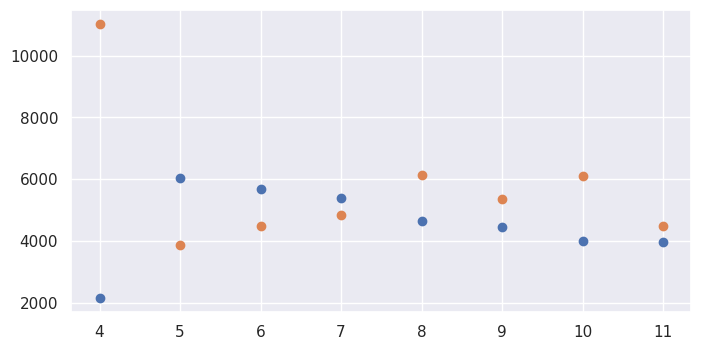

In [ ]:
plt.scatter(x,y1)
plt.scatter(x,y2)


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x, y1)

xfit = np.linspace(4, 11, 1000)
xfit = xfit.reshape(1, -1)
yfit = model.predict(xfit)

plt.scatter(x, y1)
plt.plot(xfit, yfit);

ValueError: ignored